In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning

In [161]:
# Get Artists data
artists_df = pd.read_csv('artists.csv')

# Handle missing genres by updating with missing genres from artists_missing_genres.csv
# Identify missing genres
na_genres_df = artists_df[artists_df['genres'].isna()]
print(f'{len(na_genres_df)} genres missing')

# Update missing genres
missing_genres_df = pd.read_csv('artists_missing_genres.csv')
artists_merged_df = pd.merge(artists_df, missing_genres_df[['id', 'genres']], on='id', how='left')
artists_df['genres'] = artists_df['genres'].fillna(artists_merged_df['genres_y'])

# Clean genre strings
artists_df['genres'] = [g.lower().replace('-',' ') if not isinstance(g, float) else g for g in artists_df['genres']]
print(f'{len(artists_df[artists_df['genres'].isna()])} genres missing after update')

# # Identify artists with unique genres to check for inaccuracies
# genre_counts = artists_df['genres'].value_counts()
# unique_genres = artists_df[artists_df['genres'].isin(genre_counts[genre_counts == 1].index)]
# unique_genres.sort_values(by='genres')
# artists_df[artists_df['genres'].astype(str).str.contains('seen live', na=False)]

corrected_genres = {
    'Saweetie': 'hip hop',
    'Vana': 'pop metal',
    'FWLR': 'bass house',
    'gladde paling': 'memetechno',
    'ShogunF': 'electronic',
    'Garrett Williamson': 'video game music',
    'WHIPPED CREAM': 'edm',
    'Remi Wolf': 'indie pop',
    'Daisy Grenade': 'pop punk',
    'Reneé Rap': 'pop',
    'Wildermiss': 'indie',
    'Aziya': 'indie pop'

}

corrected_genres_df = pd.DataFrame.from_dict(corrected_genres, orient='index', columns=['genres'])
corrected_genres_df  = corrected_genres_df.reset_index(names='artist_name')
artists_merged_df_2 = artists_df.merge(corrected_genres_df, on='artist_name', how='left')
artists_merged_df_2['genres_y'] = artists_merged_df_2['genres_y'].fillna(artists_merged_df_2['genres_x'])
artists_df['genres'] = artists_merged_df_2['genres_y']

# # Handle remaining null values
artists_df['genres'] = artists_df['genres'].fillna('unknown')
artists_df.head()


101 genres missing
9 genres missing after update


,id,artist_name,followers,genres,popularity
0,00CYRdkMnA0mwfy1VQPA7X,ellis,42857,future house,46
1,2f9PTWJfMMDTAFZcvHy1Z5,OVERWERK,143567,electronic,45
2,6UocZe4AprSYBvmn3J0oqY,Shiny Toy Guns,131298,electronic rock,42
3,3gk0OYeLFWYupGFRHqLSR7,Showtek,483101,hardstyle,62
4,5jdbH48Rcr1jvVSVG0osQK,DNVR,4687,bass house,26


In [162]:
# Get Tracks data
tracks_df = pd.read_csv('tracks.csv')

# Convert added at into date, time, and day of week
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at']).dt.tz_convert('US/Pacific')
tracks_df['added_at_date'] = tracks_df['added_at'].dt.date
tracks_df['added_at_month'] = tracks_df['added_at'].dt.to_period('M')
tracks_df['added_at_time'] = tracks_df['added_at'].dt.hour
tracks_df['added_at_dow_val'] = tracks_df['added_at'].dt.dayofweek.values
tracks_df['added_at_dow_name'] = tracks_df['added_at'].dt.day_name()

# Convert release date into date
tracks_df['album_release_date'] = pd.to_datetime(tracks_df['album_release_date'], format='mixed', utc=True)
tracks_df['release_dow_val'] = tracks_df['album_release_date'].dt.dayofweek.values
tracks_df['release_dow_name'] = tracks_df['album_release_date'].dt.day_name()
tracks_df['release_year'] = tracks_df['album_release_date'].dt.year
tracks_df['release_add_delta'] = round((tracks_df['added_at'] - tracks_df['album_release_date']).astype(np.int64) / (60 * 60 * 24 * 10**9)) # Days

tracks_df.head()

C:\Users\ledge\AppData\Local\Temp\ipykernel_25832\2420622140.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tracks_df['added_at_month'] = tracks_df['added_at'].dt.to_period('M')


,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,popularity,album_type,album_id,...,album_release_date,added_at_date,added_at_month,added_at_time,added_at_dow_val,added_at_dow_name,release_dow_val,release_dow_name,release_year,release_add_delta
0,2025-03-04 15:34:01-08:00,6ZRxnIHvjN0qTVRwz3PLtO,Smells Blood,4L0gz16xuM1as1OgYzh1SR,Kensuke Ushio,109280,False,56,album,05xPgo0O1tujgg6eDzIfxV,...,2018-01-10 00:00:00+00:00,2025-03-04,2025-03,15,1,Tuesday,2,Wednesday,2018,2611.0
1,2025-03-04 10:52:29-08:00,4rk94uEZLJftdhnjp4Hwsx,Conflict,1ldNdtZX38LAsOk0ciLvb2,F.O.O.L,187527,False,32,single,6z5absG3SjLYPN8AhVcO0e,...,2020-04-06 00:00:00+00:00,2025-03-04,2025-03,10,1,Tuesday,0,Monday,2020,1794.0
2,2025-03-04 10:47:34-08:00,0Obvb0dyqdOPyjWJJKMniU,Window Shop,7fVp0A6oCMfiQJihMnY0SZ,KNOWER,175208,False,29,album,7o5y1ttfkpL6zf6P2uCYPQ,...,2010-10-01 00:00:00+00:00,2025-03-04,2025-03,10,1,Tuesday,4,Friday,2010,5269.0
3,2025-03-04 10:01:50-08:00,4MqJUXLycUCczH67JE06TA,Selecta 40',7wXSDFysHTrrNetXFfvTsF,NØKK,229714,False,8,single,3g3pfrt11jiC09HSLZKLBK,...,2024-05-17 00:00:00+00:00,2025-03-04,2025-03,10,1,Tuesday,4,Friday,2024,292.0
4,2025-03-03 09:04:51-08:00,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,...,2025-02-14 00:00:00+00:00,2025-03-03,2025-03,9,0,Monday,4,Friday,2025,18.0


In [163]:
# merge
artists_df= artists_df.rename(columns={'id': 'artist_id'})
merged_df = pd.merge(tracks_df, artists_df, on='artist_id')

# Clean dupicate columns
merged_df = merged_df.rename(columns={'popularity_x': 'track_popularity', 'popularity_y': 'artist_popularity', 'followers': 'artist_followers', 'artist_name_x':'artist_name'})
merged_df.drop(columns='artist_name_y', inplace=True)
merged_df.head()

,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,track_popularity,album_type,album_id,...,added_at_time,added_at_dow_val,added_at_dow_name,release_dow_val,release_dow_name,release_year,release_add_delta,artist_followers,genres,artist_popularity
0,2025-03-04 15:34:01-08:00,6ZRxnIHvjN0qTVRwz3PLtO,Smells Blood,4L0gz16xuM1as1OgYzh1SR,Kensuke Ushio,109280,False,56,album,05xPgo0O1tujgg6eDzIfxV,...,15,1,Tuesday,2,Wednesday,2018,2611.0,138638,anime,57
1,2025-03-04 10:52:29-08:00,4rk94uEZLJftdhnjp4Hwsx,Conflict,1ldNdtZX38LAsOk0ciLvb2,F.O.O.L,187527,False,32,single,6z5absG3SjLYPN8AhVcO0e,...,10,1,Tuesday,0,Monday,2020,1794.0,88300,synthwave,46
2,2025-03-04 10:47:34-08:00,0Obvb0dyqdOPyjWJJKMniU,Window Shop,7fVp0A6oCMfiQJihMnY0SZ,KNOWER,175208,False,29,album,7o5y1ttfkpL6zf6P2uCYPQ,...,10,1,Tuesday,4,Friday,2010,5269.0,141041,experimental,41
3,2025-03-04 10:01:50-08:00,4MqJUXLycUCczH67JE06TA,Selecta 40',7wXSDFysHTrrNetXFfvTsF,NØKK,229714,False,8,single,3g3pfrt11jiC09HSLZKLBK,...,10,1,Tuesday,4,Friday,2024,292.0,247,uk garage,7
4,2025-03-03 09:04:51-08:00,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,...,9,0,Monday,4,Friday,2025,18.0,20013528,pop,91


## Exploratory Data Analysis

In [164]:
saves_by_date = merged_df.groupby(['added_at_date']).agg({'track_id': 'count'})
saves_by_date.rename(columns={'track_id':'tracks_saved'}, inplace=True)
saves_by_date = saves_by_date.reset_index()
saves_by_date = saves_by_date.sort_values(by='added_at_date')

start_date = saves_by_date.head(1)['added_at_date'].iloc[0]
end_date = saves_by_date.tail(1)['added_at_date'].iloc[0]

full_date_range = pd.DataFrame()
saves_by_date['added_at_date'] = pd.to_datetime(saves_by_date['added_at_date'], utc=True).dt.tz_convert('US/Pacific')
full_date_range['added_at_date'] = pd.date_range(start=start_date,end=end_date)
full_date_range['added_at_date'] = pd.to_datetime(full_date_range['added_at_date'], utc=True).dt.tz_convert('US/Pacific')
full_date_range = full_date_range.merge(saves_by_date, on='added_at_date', how='left')
full_date_range['tracks_saved'] = full_date_range['tracks_saved'].fillna(0)
full_date_range['added_at_date'] = full_date_range['added_at_date'].dt.strftime('%Y-%m-%d')
full_date_range.head()

,added_at_date,tracks_saved
0,2024-04-27,5.0
1,2024-04-28,0.0
2,2024-04-29,0.0
3,2024-04-30,1.0
4,2024-05-01,0.0


In [165]:
start, end, total_days = full_date_range['added_at_date'].iloc[0], full_date_range['added_at_date'].iloc[-1], len(full_date_range)
average, mode, max = full_date_range['tracks_saved'].mean(), full_date_range['tracks_saved'].mode().iloc[0], full_date_range['tracks_saved'].max()
print(f'From {start} to {end} ({total_days} days), I saved an average of {int(round(average, 0))} songs per day. The most songs I saved in a day was {int(max)}. Most days I save {int(mode)} songs.')

From 2024-04-27 to 2025-03-03 (311 days), I saved an average of 2 songs per day. The most songs I saved in a day was 18. Most days I save 0 songs.


In [166]:
month_counts = merged_df['added_at_month'].value_counts()
print(f'My top three months for saving new music were:')
for i in range(3):
    print(f'{i+1}. {month_counts.index[i].strftime('%B')} with {month_counts.iloc[i]} songs')

My top three months for saving new music were:
1. August with 109 songs
2. October with 65 songs
3. June with 65 songs


In [167]:
genre_counts = merged_df['genres'].value_counts()
print(f'Top 5 genres:')
for i in range(5):
    print(f'{i+1}. {genre_counts.index[i]}')

Top 5 genres:
1. dubstep
2. breakcore
3. electronic
4. drum and bass
5. pop


In [168]:
artist_counts = merged_df['artist_name'].value_counts()
print(f'Top 5 artists:')
for i in range(5):
    print(f'{i+1}. {artist_counts.index[i]}')

Top 5 artists:
1. Virtual Riot
2. REAPER
3. Charli xcx
4. Rezz
5. Chappell Roan


In [169]:
weekly_saves_df = merged_df.groupby(['added_at_dow_val']).aggregate({'track_id': 'count', 'added_at_dow_name': 'first' }).sort_values(by='track_id', ascending=False).reset_index()
print(f'The top three days I save new music are:')
for i in range(3):
    print(f'{i+1}. {weekly_saves_df.iloc[i, 2]} with {weekly_saves_df.iloc[i, 1]} songs')

The top three days I save new music are:
1. Wednesday with 100 songs
2. Friday with 81 songs
3. Thursday with 79 songs


<Axes: xlabel='release_add_delta', ylabel='Count'>

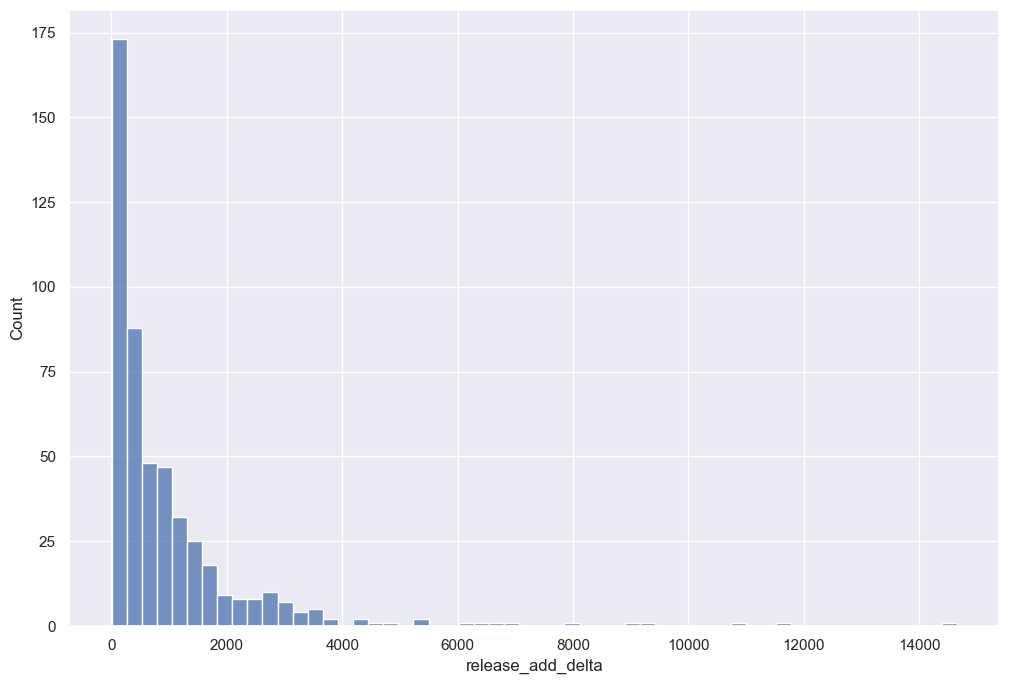

In [170]:
sns.histplot(merged_df['release_add_delta'])

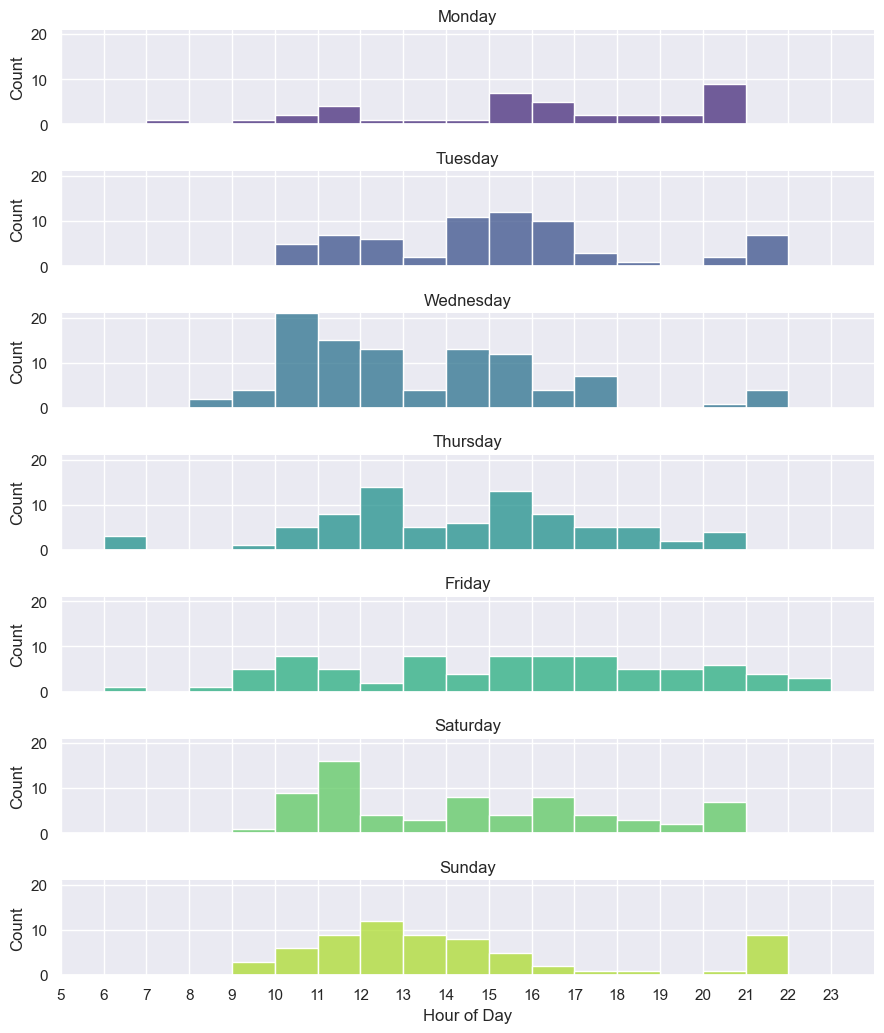

In [171]:
sns.set_theme()
pal = sns.color_palette("viridis", 7)
g = sns.FacetGrid(tracks_df.sort_values(by='added_at_dow_val'), row="added_at_dow_name", hue="added_at_dow_val", aspect=6, height=1.5, palette=pal)
g.set_titles("{row_name}")
g.map(sns.histplot, "added_at_time", binwidth=1)
g.set(xlim=(5, 24), ylim=(0, 21))
plt.xticks(np.arange(5, 24, 1))
g.set_xlabels('Hour of Day')


# # Set transparent background
# g.figure.patch.set_alpha(0)  # Figure background
# for ax in g.axes.flat:
#     ax.set_facecolor("none")  # Axes background
# g.despine()


I saved music ranging from 1985 to 2025. The most common release year I saved was 2024.


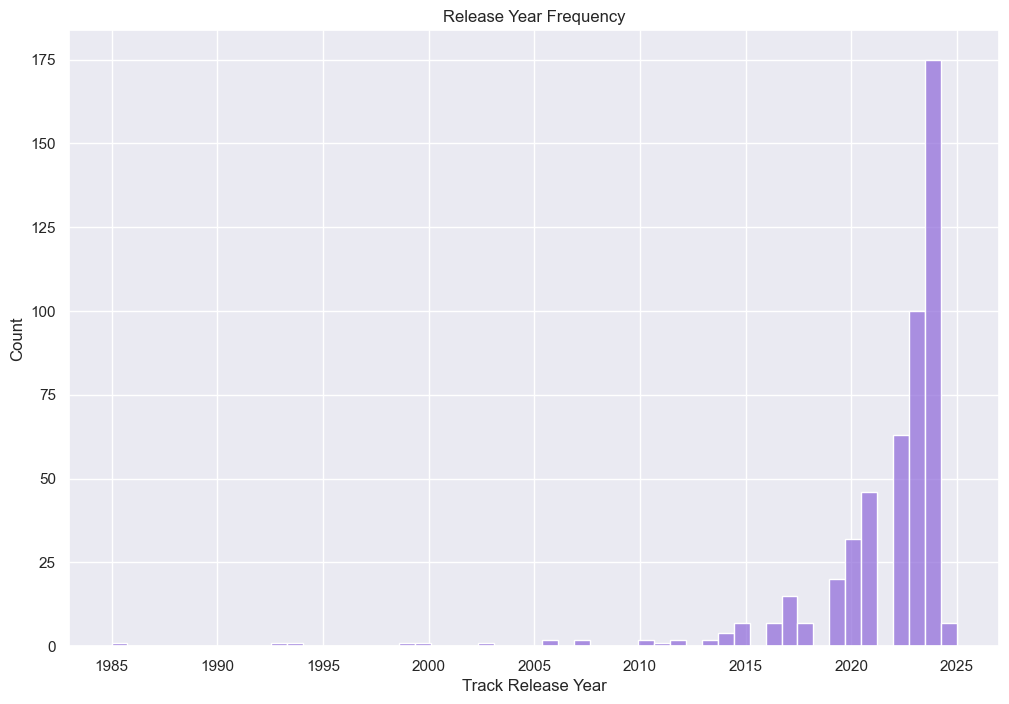

In [172]:
sns.histplot(merged_df['release_year'],color='mediumpurple')
plt.title('Release Year Frequency')
plt.xlabel('Track Release Year')
min, max, mode = merged_df['release_year'].min(), merged_df['release_year'].max(), merged_df['release_year'].mode().iloc[0]
print(f'I saved music ranging from {min} to {max}. The most common release year I saved was {mode}.')

In [173]:
# Filter out songs that were released in the last 5 years
last_5_years = merged_df[merged_df['release_year'] >= 2020]
count = last_5_years['release_add_delta'].count()
print(f'I saved {count} songs that were released in the last 5 years.')

I saved 423 songs that were released in the last 5 years.


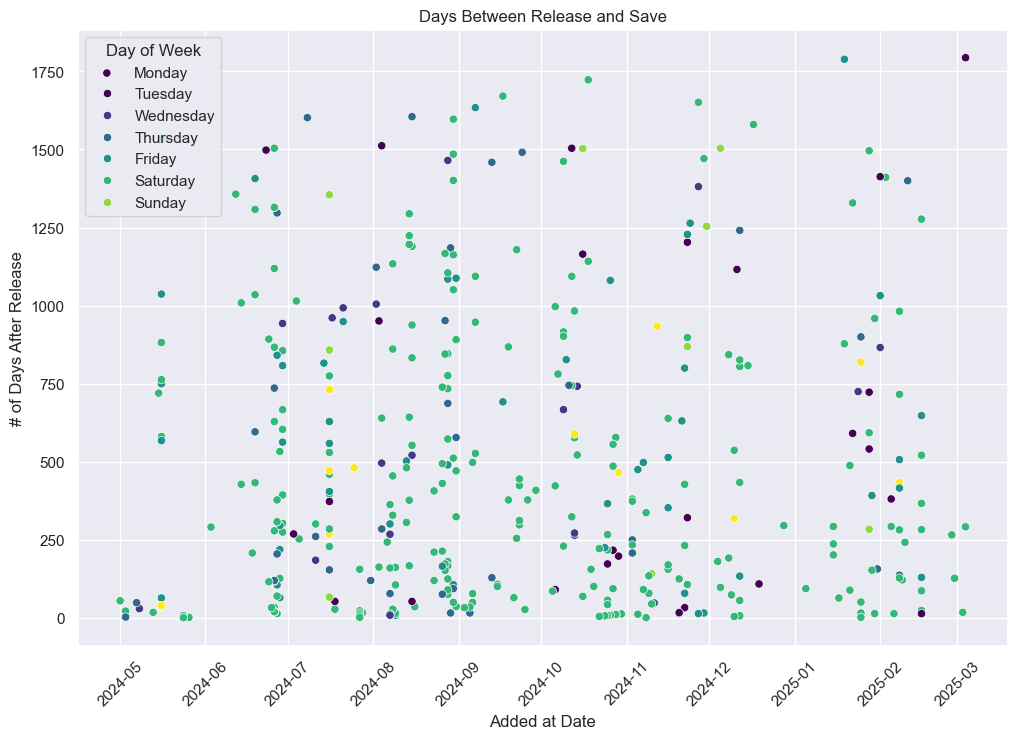

In [174]:
sns.scatterplot(data=last_5_years, x='added_at_date',y='release_add_delta', hue='release_dow_val', palette='viridis')
plt.xticks(rotation=45)
plt.title('Days Between Release and Save')
plt.xlabel('Added at Date')
plt.ylabel('# of Days After Release')
plt.legend(title='Day of Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

In [175]:
pearson_corr = last_5_years['release_dow_val'].corr(last_5_years['release_add_delta'], method='pearson')
print(f'The pearson correlation of {round(pearson_corr,2)} shows that there is no correlation between the day of the week a song was released and the amount of time it took for me to save it.')

The pearson correlation of -0.1 shows that there is no correlation between the day of the week a song was released and the amount of time it took for me to save it.


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2025-03'),
  Text(1, 0, '2025-02'),
  Text(2, 0, '2025-01'),
  Text(3, 0, '2024-12'),
  Text(4, 0, '2024-11'),
  Text(5, 0, '2024-10'),
  Text(6, 0, '2024-09'),
  Text(7, 0, '2024-08'),
  Text(8, 0, '2024-07'),
  Text(9, 0, '2024-06'),
  Text(10, 0, '2024-05'),
  Text(11, 0, '2024-04')])

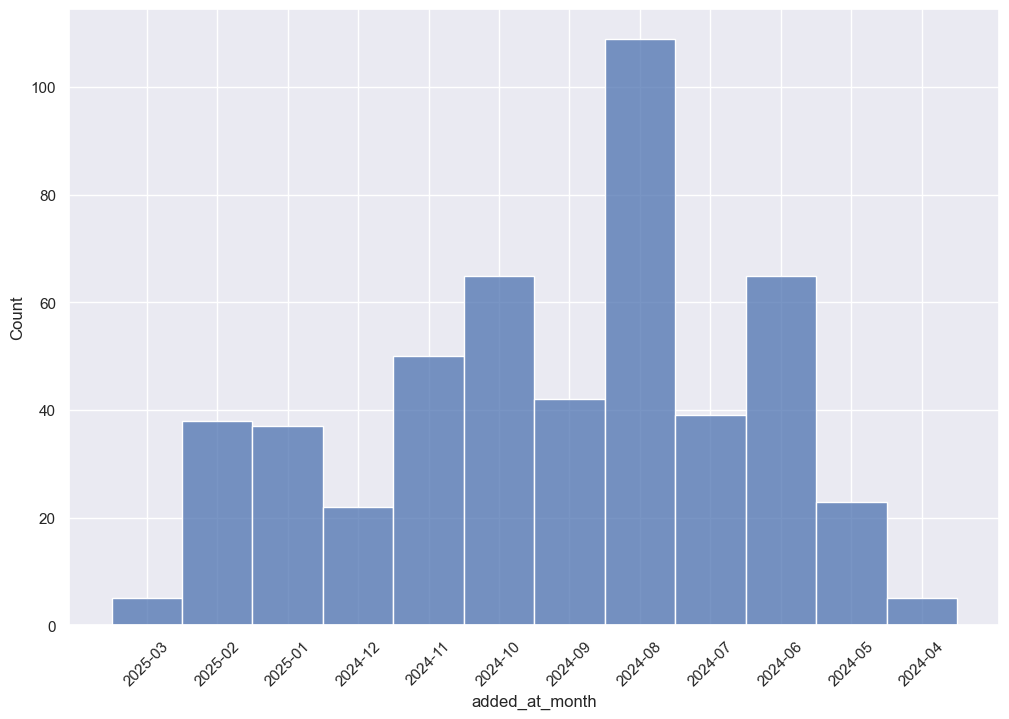

In [176]:
convert_months = merged_df['added_at_month'].dt.strftime('%Y-%m')
convert_months.sort_values()
sns.histplot(convert_months)
plt.xticks(rotation=45)

In [177]:
top_genres = genre_counts[:5]
top_songs_by_genre = merged_df[merged_df['genres'].isin(top_genres.index)]
# song_genre_counts = top_songs_by_genre['genres'].value_counts()
# song_genre_counts
# top_songs_by_genre = top_songs_by_genre.sort_values(by='genres', key=lambda x: x.map(song_genre_counts), ascending=False)
top_songs_by_genre.head()

,added_at,track_id,track_name,artist_id,artist_name,duration,explicit,track_popularity,album_type,album_id,...,added_at_time,added_at_dow_val,added_at_dow_name,release_dow_val,release_dow_name,release_year,release_add_delta,artist_followers,genres,artist_popularity
4,2025-03-03 09:04:51-08:00,1zhvxTuSha22nsUT5Nw8gE,15 Minutes,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,191519,True,79,album,3WzBIQmn2hrulLeTY9smkk,...,9,0,Monday,4,Friday,2025,18.0,20013528,pop,91
5,2025-02-28 22:01:33-08:00,5GGA54O0NQK6Bo7nI0cz5k,SUPERSCAR,2qanRMyA5bNuTvz1dK45OP,ADÉLA,194040,False,59,single,2pElP8JopnqWCAEujfbhBL,...,22,4,Friday,4,Friday,2024,127.0,59043,pop,51
7,2025-02-16 12:29:35-08:00,3EgRznELSayrCj19aGYRic,Woah!! (feat. kets4eki),0hrMKLqgNEIemiF4Ag8dTI,Sophie Powers,177000,False,34,single,0vCm9yXPMOX7BpLtuB0YjC,...,12,6,Sunday,4,Friday,2024,283.0,75957,pop,48
12,2025-02-16 11:18:37-08:00,3rUGC1vUpkDG9CZFHMur1t,greedy,45dkTj5sMRSjrmBSBeiHym,Tate McRae,131872,True,81,single,3UOV8XvCwMKaATRNXrYCjN,...,11,6,Sunday,4,Friday,2023,521.0,7048840,pop,90
13,2025-02-16 11:15:58-08:00,2zOmS55knKWSgScYPTNmGQ,Sports car,45dkTj5sMRSjrmBSBeiHym,Tate McRae,165045,False,84,single,1fOTqAU8mRMHlmOaHMqsge,...,11,6,Sunday,4,Friday,2025,24.0,7048840,pop,90


([<matplotlib.axis.XTick at 0x1543cc4b890>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

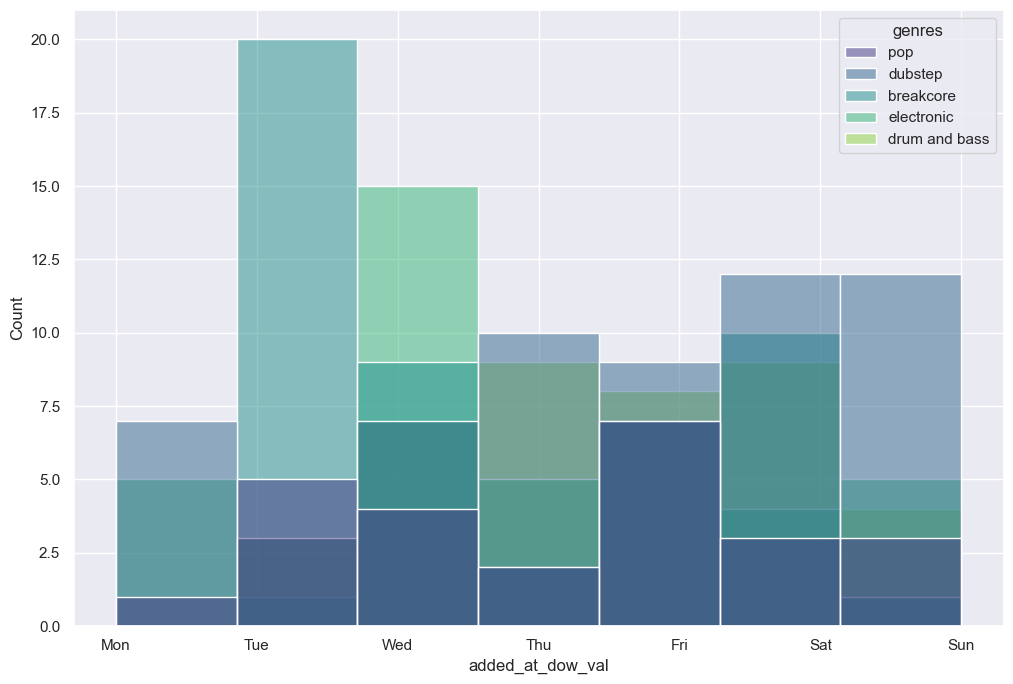

In [178]:
sns.histplot(data=top_songs_by_genre, x='added_at_dow_val', hue='genres', palette='viridis',bins=7)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

In [179]:
# Want best time slots to advertise new pop music
# Look at genre over saved date/time
# 

# User stories, Jacq vs Merc vs Luis, can we be categorized into different "types" of users
# What characteristics define those users?
# New music seeker vs Merc songs of the week

# What kind of spotify user am I?
# Does release day of week matter to me? Am I more likely to save a song if it's released on a certain day?

What length of songs am I most frequently saving?

How many followers do the artists I have saved usually have?

Which day of the week am I saving the most songs?

Which time slot of the week am I saving the most songs?

Is there statistical significance between day of the week and added at time?

What time frame after song release am I most frequently saving songs?

Is there a correlation between the day of the week that a song was released and the time taken before saving it?

Is there a correlation between the artist's followers/popularity and the time it takes before I save the song?

What's my top genre?

What patterns of genre saving are there over time? 